## Image based simulations

## Import necessary packages

In [2]:
import os
import warnings
import h5py
import numpy as np
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

## Generate image from porespy: create a 3D image using PoreSpy’s poly_disperese_spheres generator

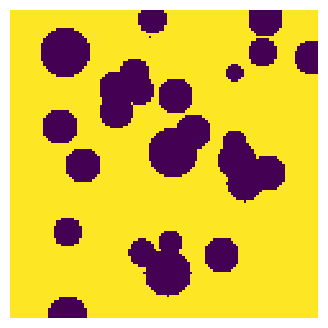

In [13]:
np.random.seed(0)
shape = [120, 120, 50]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Computing the tortuosity

In [14]:
results = ps.simulations.tortuosity_fd(im=im, axis=1)
print(results)

[09:58:09] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=274038;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=216310;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#74\74]8;;\

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Tue Oct 22 09:58:12 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (120, 120, 50)
tortuosity                1.3136413678499625
formation_factor          1.8945232450364011
original_porosity         0.6934138888888889
effective_porosity        0.6933888888888889
concentration             Array of size (120, 120, 50)
sys                       (<COOrdinate sparse matrix of dtype 'float64'
	with 3303896 stored elements and shape (499240, 499240)>, array([5.73753305, 5.73753305, 5.73753305, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## Extract the network using snow2 algorithm

In [15]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None)
regions = snow.regions
net = snow.network

### Computing the diffusive size factor and assigning it to the network

In [16]:
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD

Preparing images and DNS calculations:   0%|          | 0/338 [00:00<?, ?it/s]

### These are the code for plotting 3D relative permeability and relative diffusivity of simulations

In [9]:
import os

def plot_relative_permeability(results, network, im, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        kr_air = results['kr_air'][direction]
        kr_water = results['kr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_permeability_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot saved at {plot_path}")

    # Network Visualization
    # Microstructure visualization
    fig, ax = plt.subplots(1, 1, figsize=[4, 4], dpi=300)
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)
    microstructure_path = os.path.join(save_dir, "microstructure.png")
    plt.savefig(microstructure_path, format='png')
    plt.close(fig)
    print(f"Microstructure image saved at {microstructure_path}")

    # Network connectivity visualization
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    ax = op.visualization.plot_connections(network, ax=ax)
    ax = op.visualization.plot_coordinates(network, ax=ax)
    network_plot_path = os.path.join(save_dir, "network_plot.png")
    plt.savefig(network_plot_path, format='png')
    plt.close(fig)
    print(f"Network plot saved at {network_plot_path}")

    # Save network information
    network_info_path = os.path.join(save_dir, "network_info.txt")
    with open(network_info_path, 'w') as f:
        f.write(str(network))
    print(f"Network information saved at {network_info_path}")
    
    salome_file = save_dir + 'network_to_salome'
    ## Export to Salome
    op.io.network_to_salome(pn,filename=str(salome_file))

    # Save the network to salome
    
def plot_relative_diffusivity(results, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        Dr_air = results['Dr_air'][direction]
        Dr_water = results['Dr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation,Dr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_Dr_air, label=f'Dr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_Dr_water, label=f'Dr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Diffusivity (Dr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Diffusivity in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_diffusivity_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative diffusivity plot saved at {plot_path}")
    plt.show()


## Simulation from artificial generated image
From the generated images, the pores connectivity and coordinates were extracted , and used to rebuild the network for simulations with openPNM

## Relative permeability

In [10]:
#pn['throat.volume'] = pn['throat.cross_sectional_area']*pn['throat.total_length']
import os
import h5py
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Generate microstructure

np.random.seed(0)
shape = [200, 200, 200]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Extract the nework using snow algorithm

### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD

## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD

"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']

pn.regenerate_models()
print(pn)

pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  
pn['throat.diffusive_size_factor'] = g_FD
pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)

"""
## Creating network using pore coordinates and  connectivity 
coords = pn1['pore.coords']
conns = pn1['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
""" 

print(pn)
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)


#pn.regenerate_models()
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)
print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
""" 
Ps = pn['pore.cluster_size'] < 100
op.topotools.trim(network=pn, pores=Ps)
ax = op.visualization.plot_tutorial(pn, font_size=8)
"""
###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('zmin')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('zmin')
flow_out = pn.pores('zmax')

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores(inlet)
    Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
    ip.set_inlet_BC(pores=Finlets)
    ip.run()
    max_seq = np.max([np.max(ip['pore.invasion_sequence']),
            np.max(ip['throat.invasion_sequence'])])
    start = max_seq//Snwp_num
    stop = max_seq
    step = max_seq//Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models();
        water.regenerate_models();
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
        relperm_wp.append(Rate_ewp/Rate_abs_wp)
        
               # Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['kr_air'][direction] = np.array(relperm_nwp).flatten()
        results['kr_water'][direction] = np.array(relperm_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        kr_air = np.array(relperm_nwp).flatten()
        kr_water = np.array(relperm_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)
        

# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1376 [00:00<?, ?it/s]

Preparing images and DNS calculations:   0%|          | 0/4368 [00:00<?, ?it/s]

: 

### Compute relative permeability for different porosities

In [ ]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os

# Define the porosity values you want to simulate
porosity_values = [0.3,0.4,0.5, 0.6, 0.7, 0.8]

# Initialize results dictionary for storing results for each porosity
simulation_results = {}

# Loop through each porosity value
for porosity in porosity_values:
    print(f"Simulating for porosity: {porosity}")
    
    ## Generate microstructure
    np.random.seed(0)
    shape = [200, 200, 200]
    dist = stats.norm(loc=7, scale=5)
    im = ps.generators.polydisperse_spheres(shape=shape,
                                            porosity=porosity,
                                            dist=dist,
                                            r_min=7)
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)

    ## Extract the network using snow algorithm
    snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']
    g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
    net['throat.diffusive_size_factor'] = g_FD

    # Create network from porespy segmented image
    pn = op.io.network_from_porespy(net)
    mods = op.models.collections.geometry.spheres_and_cylinders
    pn.add_model_collection(mods)
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    pn.regenerate_models()
    
    pn.add_model(propname='throat.hydraulic_size_factors',
                 model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                 model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    pn['throat.diffusive_size_factor'] = g_FD
    pn.regenerate_models()

    ## Check network health
    h = op.utils.check_network_health(pn)
    print(h)

    ## Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    ## Phases and properties
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 180.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()
    
    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)
    water.regenerate_models()

    # Boundary conditions for each direction
    directions = {
        'x': ('xmin', 'xmax'),
        'y': ('ymin', 'ymax'),
        'z': ('zmin', 'zmax')
    }

    # Dictionary to store simulation results for each direction
    results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

    # Run simulations for each direction
    for direction, (inlet, outlet) in directions.items():
        ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
        Finlets_init = pn.pores(inlet)
        Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
        ip.set_inlet_BC(pores=Finlets)
        ip.run()
        max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                          np.max(ip['throat.invasion_sequence'])])
        start = max_seq // 100
        stop = max_seq
        step = max_seq // 100
        Snwparr = []
        relperm_nwp = []
        relperm_wp = []

        for i in range(start, stop, step):
            air.regenerate_models()
            water.regenerate_models()
            sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
            Snwparr.append(sat)
            Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
            relperm_wp.append(Rate_ewp / Rate_abs_wp)

            # Convert results to numpy arrays
            results['saturation'][direction] = 1 - np.array(Snwparr)
            results['kr_air'][direction] = np.array(relperm_nwp).flatten()
            results['kr_water'][direction] = np.array(relperm_wp).flatten()

    # Store results for each porosity
    simulation_results[porosity] = results

    # Plot results or save as needed
    save_dir = f'rock_sample_porosity_{porosity}'
    plot_relative_permeability(results, pn, im, save_dir)

# Plot results for all porosities in one figure
def plot_relative_permeability_all(simulation_results):
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

    for idx, (porosity, results) in enumerate(simulation_results.items()):
        for direction in results['saturation'].keys():
            # Smooth the data
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]

            # Interpolation
            interp_func_air = interp1d(saturation, kr_air, kind='linear')
            interp_func_water = interp1d(saturation, kr_water, kind='linear')
            smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
            smooth_kr_air = interp_func_air(smooth_saturation)
            smooth_kr_water = interp_func_water(smooth_saturation)

            # Plotting both air and water with different styles for each direction
            ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air (Porosity {porosity}, {direction})', 
                    linestyle=line_styles[idx % len(line_styles)], linewidth=line_width, marker=marker_styles[idx % len(marker_styles)], markersize=4)
            ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water (Porosity {porosity}, {direction})', 
                    linestyle=line_styles[idx % len(line_styles)], linewidth=line_width, marker=marker_styles[idx % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Porosities in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Porosity & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    save_dir = "artificial_image/"
    
    plot_path =  save_dir+ "relative_permeability_all_porosity.png"
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all porosities saved at {plot_path}")

# Call the function to plot all results
plot_relative_permeability_all(simulation_results)

### Compute relative permeabilities for different pore size distributions

In [ ]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
from mayavi import mlab


import csv
from datetime import datetime

# Create a directory name containing date including day, hour, minute, second
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_directory = f"simulation_results_{current_time}"
os.makedirs(results_directory, exist_ok=True)

# Define the porosity values and distribution types you want to simulate
porosity_values = [0.3, 0.4, 0.5, 0.6, 0.7,0.8]
distribution_types = {
    'normal': lambda: stats.norm(loc=7, scale=5),
    'weibull': lambda: stats.weibull_min(c=2, scale=7),
    'lognormal': lambda: stats.lognorm(s=0.5, scale=np.exp(7))
}

# Initialize results dictionary for storing results for each porosity and distribution
simulation_results = {}

# File paths for storing results
csv_file_path = os.path.join(results_directory, "tortuosity_results.csv")
latex_file_path = os.path.join(results_directory, "tortuosity_results.tex")

# Write headers to CSV file if it doesn't exist
if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Distribution", "Porosity", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])


print(f"Tortuosity results saved in {csv_file_path} and {latex_file_path}")

# Loop through each distribution type
for dist_name, dist_func in distribution_types.items():
    simulation_results[dist_name] = {}
    # Loop through each porosity value
    for porosity in porosity_values:
        print(f"Simulating for distribution: {dist_name}, porosity: {porosity}")
        
        ## Generate microstructure
        np.random.seed(0)
        shape = [200, 200, 200]
        dist = dist_func()
        im = ps.generators.polydisperse_spheres(shape=shape,
                                                porosity=porosity,
                                                dist=dist,
                                                r_min=7)
        
        ### Visualization of generated image
        fig, ax = plt.subplots(1, 1, figsize=[4, 4])
        ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
        ax.axis(False)
        """ 
        # Mayavi visualization for a scientific paper
        mlab.figure(size=(800, 800), bgcolor=(1, 1, 1))
        src = mlab.pipeline.scalar_field(im)
        mlab.pipeline.iso_surface(src, contours=[im.mean()], opacity=0.3, color=(0.1, 0.5, 0.8))
        mlab.pipeline.iso_surface(src, contours=[im.max() - 0.1], color=(0.8, 0.1, 0.1))
        mlab.axes(src, color=(0, 0, 0), xlabel='X', ylabel='Y', zlabel='Z', line_width=1.5)
        mlab.outline(color=(0, 0, 0), line_width=1.5)
        mayavi_plot_path = os.path.join(results_directory, f'mayavi_visualization_{dist_name}_porosity_{porosity}.png')
        mlab.savefig(mayavi_plot_path)
        mlab.close()
        print(f"3D visualization saved at {mayavi_plot_path}")
        """
        ## Extract the network using snow algorithm
        snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size=1e-6)
        regions = snow.regions
        net = snow.network
        conns = net['throat.conns']
        g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
        net['throat.diffusive_size_factor'] = g_FD

        # Create network from porespy segmented image
        pn = op.io.network_from_porespy(net)
        mods = op.models.collections.geometry.spheres_and_cylinders
        pn.add_model_collection(mods)
        pn['pore.diameter'] = pn['pore.equivalent_diameter']
        pn['throat.diameter'] = pn['throat.inscribed_diameter']
        pn['throat.spacing'] = pn['throat.total_length']
        pn.regenerate_models()
        
        pn.add_model(propname='throat.hydraulic_size_factors',
                     model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
        pn.add_model(propname='throat.diffusive_size_factors',
                     model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
        pn['throat.diffusive_size_factor'] = g_FD
        pn.regenerate_models()

        ## Check network health
        h = op.utils.check_network_health(pn)
        print(h)

        ## Remove disconnected pores from the network
        op.topotools.trim(network=pn, pores=h['disconnected_pores'])
        h = op.utils.check_network_health(pn)
        print(h)

        ## Phases and properties
        air = op.phase.Air(network=pn, name='air')
        air['pore.surface_tension'] = 0.072
        air['pore.contact_angle'] = 180.0
        air.add_model_collection(op.models.collections.phase.air)
        air.add_model_collection(op.models.collections.physics.basic)
        air.regenerate_models()
        
        water = op.phase.Water(network=pn, name='water')
        water.add_model_collection(op.models.collections.phase.water)
        water.add_model_collection(op.models.collections.physics.basic)
        water.regenerate_models()

        # Boundary conditions for each direction
        directions = {
            'x': ('xmin', 'xmax'),
            'y': ('ymin', 'ymax'),
            'z': ('zmin', 'zmax')
        }

        # Dictionary to store simulation results for each direction
        results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

        # Run simulations for each direction
        for direction, (inlet, outlet) in directions.items():
            ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
            Finlets_init = pn.pores(inlet)
            Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
            ip.set_inlet_BC(pores=Finlets)
            ip.run()
            max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                              np.max(ip['throat.invasion_sequence'])])
            start = max_seq // 100
            stop = max_seq
            step = max_seq // 100
            Snwparr = []
            relperm_nwp = []
            relperm_wp = []

            for i in range(start, stop, step):
                air.regenerate_models()
                water.regenerate_models()
                sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
                Snwparr.append(sat)
                Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
                Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
                Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
                Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
                relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
                relperm_wp.append(Rate_ewp / Rate_abs_wp)

                # Convert results to numpy arrays
                results['saturation'][direction] = 1 - np.array(Snwparr)
                results['kr_air'][direction] = np.array(relperm_nwp).flatten()
                results['kr_water'][direction] = np.array(relperm_wp).flatten()

        # Store results for each porosity and distribution
        simulation_results[dist_name][porosity] = results

        # Plot results or save as needed
        # Plot results or save as needed
        save_dir = os.path.join(results_directory, f'rock_sample_{dist_name}_porosity_{porosity}')
        os.makedirs(save_dir, exist_ok=True)
        plot_relative_permeability(results, pn, im, save_dir)
        
        # Compute tortuosity
        tortuosity_results = ps.simulations.tortuosity_fd(im=im, axis=1)
        print(tortuosity_results)
        tortuosity = tortuosity_results['tortuosity']
        formation_factor = tortuosity_results['formation_factor']
        original_porosity = tortuosity_results['original_porosity']
        effective_porosity = tortuosity_results['effective_porosity']

        # Append results to CSV file
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([dist_name, porosity, tortuosity, formation_factor, original_porosity, effective_porosity])

# Write results to LaTeX table format
with open(csv_file_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    rows = list(csv_reader)

    with open(latex_file_path, mode='w') as latex_file:
            latex_file.write("\begin{table}[h!]
    \centering
    \begin{tabular}{|l|l|l|l|l|l|}
    \hline
    ")
            latex_file.write(" & ".join(header) + " \\
    \hline
    ")
            for row in rows:
                latex_file.write(" & ".join(row) + " \\
    \hline
    ")
            latex_file.write("\end{tabular}
    \caption{Tortuosity results for different pore size distributions and porosities.}
    \label{tab:tortuosity_results}
    \end{table}")

    print(f"Tortuosity results saved in {csv_file_path} and {latex_file_path}")

# Plot results for all porosities and distributions in one figure
def plot_relative_permeability_all_porosity_pore_dist(simulation_results):
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

    for dist_idx, (dist_name, porosity_results) in enumerate(simulation_results.items()):
        for porosity_idx, (porosity, results) in enumerate(porosity_results.items()):
            for direction in results['saturation'].keys():
                # Smooth the data
                saturation = results['saturation'][direction]
                kr_air = results['kr_air'][direction]
                kr_water = results['kr_water'][direction]

                # Interpolation
                interp_func_air = interp1d(saturation, kr_air, kind='linear')
                interp_func_water = interp1d(saturation, kr_water, kind='linear')
                smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
                smooth_kr_air = interp_func_air(smooth_saturation)
                smooth_kr_water = interp_func_water(smooth_saturation)

                # Plotting both air and water with different styles for each direction
                ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air ({dist_name}, Porosity {porosity}, {direction})', 
                        linestyle=line_styles[(dist_idx + porosity_idx) % len(line_styles)], linewidth=line_width, marker=marker_styles[(dist_idx + porosity_idx) % len(marker_styles)], markersize=4)
                ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water ({dist_name}, Porosity {porosity}, {direction})', 
                        linestyle=line_styles[(dist_idx + porosity_idx) % len(line_styles)], linewidth=line_width, marker=marker_styles[(dist_idx + porosity_idx) % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Porosities and Distributions in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Distribution, Porosity & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(results_directory, "relative_permeability_all_porosity_distributions.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all porosities and distributions saved at {plot_path}")

# Call the function to plot all results
plot_relative_permeability_all_porosity_pore_dist(simulation_results)

### Pore shape factor impact on relative humidity

### Pore shape and anisotropy factor 




[19:10:06] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=18776;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=205733;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#74\74]8;;\

im1 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Tue Oct 29 19:10:06 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200)
tortuosity                2.689835094825434
formation_factor          4.715906368311083
original_porosity         0.6185
effective_porosity        0.570375
concentration             Array of size (200, 200)
sys                       (<COOrdinate sparse matrix of dtype 'float64'
	with 110295 stored elements and shape (22815, 22815)>, array([3.86280956, 1.        , 0.        , ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=619390;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=4339;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#74\74]8;;\

im2 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Tue Oct 29 19:10:06 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200)
tortuosity                3.5498049499758855
formation_factor          6.098797268234492
original_porosity         0.606775
effective_porosity        0.58205
concentration             Array of size (200, 200)
sys                       (<COOrdinate sparse matrix of dtype 'float64'
	with 108748 stored elements and shape (23282, 23282)>, array([3.70552358, 1.        , 0.        , ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=907559;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=192414;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#74\74]8;;\

im3 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Tue Oct 29 19:10:06 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200)
tortuosity                4.751457791107616
formation_factor          8.099651039603863
original_porosity         0.594725
effective_porosity        0.586625
concentration             Array of size (200, 200)
sys                       (<COOrdinate sparse matrix of dtype 'float64'
	with 109349 stored elements and shape (23465, 23465)>, array([3.69281909, 1.        , 0.        , ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=191497;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=334320;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#74\74]8;;\

           ERROR    Inlet/outlet rates don't match: 3.8461e-02 vs. -3.8457e-02                          ]8;id=93139;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=736999;file:///opt/anaconda3/lib/python3.11/site-packages/porespy/simulations/_dns.py#107\107]8;;\

im4 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Tue Oct 29 19:10:06 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200)
tortuosity                15.111469606300039
formation_factor          26.130848359502057
original_porosity         0.596525
effective_porosity        0.5783
concentration             Array of size (200, 200)
sys                       (<COOrdinate sparse matrix of dtype 'float64'
	with 108300 stored elements and shape (23132, 23132)>, array([0., 0., 0., ..., 0., 0., 0.]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


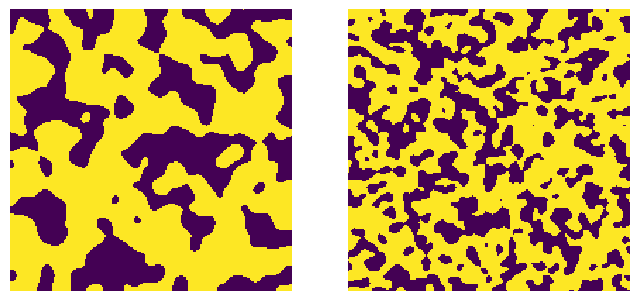

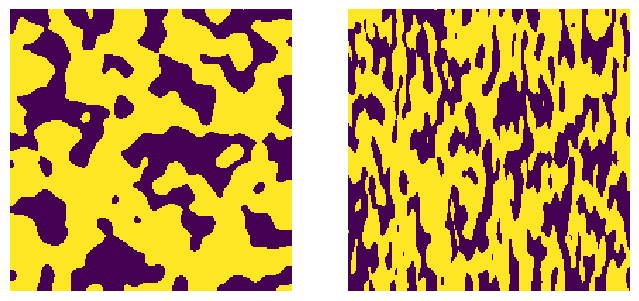

In [ ]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
from mayavi import mlab

np.random.seed(0)
e=0.6
shape = [200,200]
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

im1 = ps.generators.blobs(shape=shape, porosity=e, blobiness=1)
ax[0].imshow(im1, origin='lower', interpolation='none')
ax[0].axis(False)

 # Compute tortuosity
tortuosity_results = ps.simulations.tortuosity_fd(im=im1, axis=1)
print("im1",tortuosity_results)


im2 = ps.generators.blobs(shape=shape, porosity=e, blobiness=2)
ax[1].imshow(im2, origin='lower', interpolation='none')
ax[1].axis(False);

 #Compute tortuosity
tortuosity_results = ps.simulations.tortuosity_fd(im=im2, axis=1)
print("im2",tortuosity_results)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])

im3 = ps.generators.blobs(shape=shape, porosity=e, blobiness=[2, 2])
ax[0].imshow(im1, origin='lower', interpolation='none')
ax[0].axis(False)

 # Compute tortuosity
tortuosity_results = ps.simulations.tortuosity_fd(im=im3, axis=1)
print("im3",tortuosity_results)

im4 = ps.generators.blobs(shape=shape, porosity=e, blobiness=[1, 3])
ax[1].imshow(im4, origin='lower', interpolation='none')
ax[1].axis(False);
 # Compute tortuosity
tortuosity_results = ps.simulations.tortuosity_fd(im=im4, axis=1)
print("im4",tortuosity_results)


## Scientific visualization

### Compute relative permeability for multiscale image

## Simulation from experimental acquired image stored in Digital Rock portal

In [6]:
import os
import numpy as np

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

def load_image_to_3d(filename, data_type, voxelsx=None, voxelsy=None):
    """
    Loads a raw image from the specified path or URL, reshapes it into 3D based on inferred dimensions.
    Assumes a cubic image by default if no dimensions are provided.

    Parameters:
    path (str): Directory where the image will be saved.
    name (str): Name of the image file.
    url (str): URL to download the image if not already present.
    data_type (str): Data type for reading the image file (e.g., '<i1' for 1-byte signed integer).
    voxel_size (float): The size of each voxel in meters.
    voxelsx (int, optional): Known voxel count along the x-dimension. If not provided, assumes cubic.
    voxelsy (int, optional): Known voxel count along the y-dimension. If not provided, assumes cubic.

    Returns:
    im (numpy.ndarray): The reshaped 3D image.
    (voxelsx, voxelsy, voxelsz) (tuple of int): The inferred voxel dimensions.
    """
    # Ensure the directory exists

    # Load the raw image data
    image_data = np.fromfile(filename, dtype=data_type)
    
    # Total number of voxels
    total_voxels = image_data.size
    
    # If no dimensions are provided, assume the image is cubic
    if voxelsx is None and voxelsy is None:
        # Assuming a cubic image, calculate the side length
        voxelsx = int(round(total_voxels ** (1/3)))
        voxelsy = voxelsx
        voxelsz = voxelsx
    elif voxelsx is not None and voxelsy is not None:
        # If both voxelsx and voxelsy are provided, infer voxelsz
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    elif voxelsx is not None and voxelsy is None:
        # If only voxelsx is provided, assume a cubic y-dimension and infer z-dimension
        voxelsy = voxelsx
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    else:
        raise ValueError("You must provide at least one dimension (voxelsx) to infer the others if the image is not cubic.")
    
    # Reshape the image into the inferred 3D dimensions
    im = np.reshape(image_data, (voxelsx, voxelsy, voxelsz))
    
    # Return the reshaped image and its dimensions
    return im, (voxelsx, voxelsy, voxelsz)


In [7]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")


## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'rock_sample_Leopard'
name = 'image_Leopard.raw'
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

data_type = '<i1'  # 1-byte signed integer
voxel_size = 2.25e-6  # Voxel size in meters

# Assume cubic image
image, dimensions = load_image_to_3d(path, name, url, data_type, voxel_size)

print(f"Reshaped 3D image has dimensions: {dimensions}")

### Identify pore space and solid space
# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

im = im[:250,:250,:250]

### Reduce the size of the image to be more manageable
""" 
coords = net_drp ['pore.coords']
conns = net_drp['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)

"""
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network

## uncomment to Compute diffusive size factor if needed and assign it to the network

""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD
"""

#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)

pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)

pn.regenerate_models()
## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)


ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores(inlet)
    Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
    ip.set_inlet_BC(pores=Finlets)
    ip.run()
    max_seq = np.max([np.max(ip['pore.invasion_sequence']),
            np.max(ip['throat.invasion_sequence'])])
    start = max_seq//Snwp_num
    stop = max_seq
    step = max_seq//Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models();
        water.regenerate_models();
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
        relperm_wp.append(Rate_ewp/Rate_abs_wp)
        
               # Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['kr_air'][direction] = np.array(relperm_nwp).flatten()
        results['kr_water'][direction] = np.array(relperm_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        kr_air = np.array(relperm_nwp).flatten()
        kr_water = np.array(relperm_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)


TypeError: load_image_to_3d() takes from 2 to 4 positional arguments but 5 were given

In [8]:
# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

NameError: name 'plot_relative_permeability' is not defined

In [ ]:

## Drainage simulations
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pn.pores('left'))
drn.run()

water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']


diff_in = pn.pores('left')
diff_out = pn.pores('right')

## Define multiphase conductance
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

## Calculate the relative diffusivity
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update_diffusivity(pn, water, air)
    Snwparr.append(sat_point)
    Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
    
## Calculate the relative permeability
plt.figure(figsize=[6,5])
plt.plot(Snwparr, reldiff_nwp, '*-', label='Dr_nwp')
plt.plot(Snwparr, reldiff_wp, 'o-', label='Dr_wp')
plt.xlabel('Snwp')
plt.ylabel('Dr')
plt.title('Relative Diffusivity in x direction')
plt.legend()

Reshaped 3D image has dimensions: (1000, 1000, 1000)
0.353452


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1718 [00:00<?, ?it/s]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x2af44eed0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  2034 / 2034
  3  pore.coords                                                   1718 / 1718
  4  pore.region_label                                             1718 / 1718
  5  pore.phase                                                    1718 / 1718
  6  throat.phases                                                 2034 / 2034
  7  pore.region_volume                                            1718 / 1718
  8  pore.equivalent_diameter                                      1718 / 1718
  9  pore.local_peak                                               1718 / 1718
 10 

[18:17:35] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=625969;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py\_models.py]8;;\:]8;id=684225;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

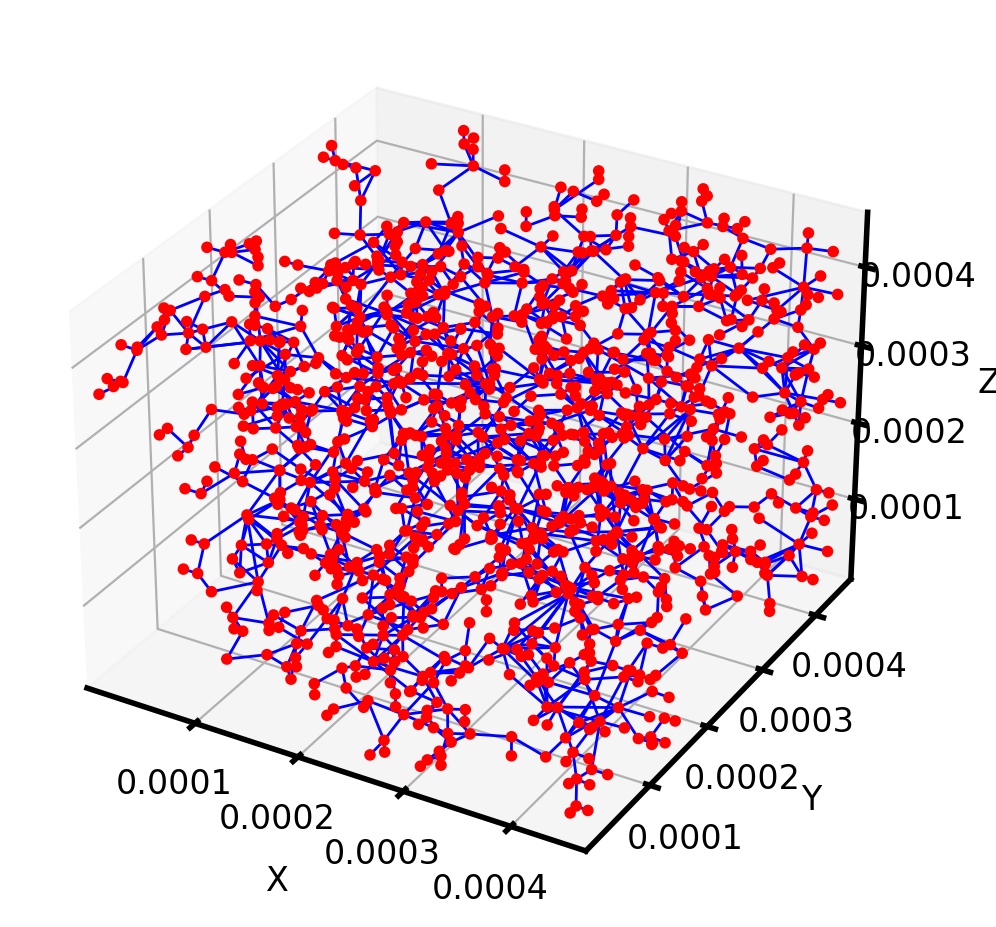

In [43]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")


## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'rock_sample_Leopard'
name = 'image_Leopard.raw'
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

data_type = '<i1'  # 1-byte signed integer
voxel_size = 2.25e-6  # Voxel size in meters

# Assume cubic image
image, dimensions = load_image_to_3d(path, name, url, data_type, voxel_size)

print(f"Reshaped 3D image has dimensions: {dimensions}")

### Identify pore space and solid space
# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

im = im[:400,:400,:400]


### Reduce the size of the image to be more manageable

""" 
coords = net_drp ['pore.coords']
conns = net_drp['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
"""

from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)

"""
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 

conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD
"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)


pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  

pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)
## Export to Salome
op.io.network_to_salome(pn,filename='salome/image_Leopard')

ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

"""
def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    Returns:
    Array of diffusivities.
    """
    
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    
    """
    Computes the viscosity using the Einstein-Stokes equation.
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    Returns:
    Array of viscosities.
    """
    
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

def sat_update_diffusivity(network, nwp, wp):
        
        """
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

def Rate_calc_diffusivity(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val
    
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'Dr_air': {}, 'Dr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    ## Drainage simulations
    drn = op.algorithms.Drainage(network=pn, phase=water)
    drn.set_inlet_BC(pn.pores(inlet))
    drn.run()

    water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
        
    diff_in = pn.pores(inlet)
    diff_out = pn.pores(outlet)
    ## Calculate the relative diffusivity
    Snwparr = []
    reldiff_nwp = []
    reldiff_wp = []
    for Pc in np.unique(drn['pore.invasion_pressure']):
        water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
        water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
        air['pore.occupancy'] = 1 - water['pore.occupancy']
        air['throat.occupancy'] = 1 - water['throat.occupancy']
        air.regenerate_models()
        water.regenerate_models()
        sat_point = sat_update_diffusivity(pn, water, air)
        Snwparr.append(sat_point)
        Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
        reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
        
        #Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['Dr_air'][direction] = np.array(reldiff_nwp).flatten()
        results['Dr_water'][direction] = np.array(reldiff_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        Dr_air = np.array(reldiff_nwp).flatten()
        Dr_water = np.array(reldiff_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation, Dr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)


# Berea sandstone

KeyboardInterrupt: 

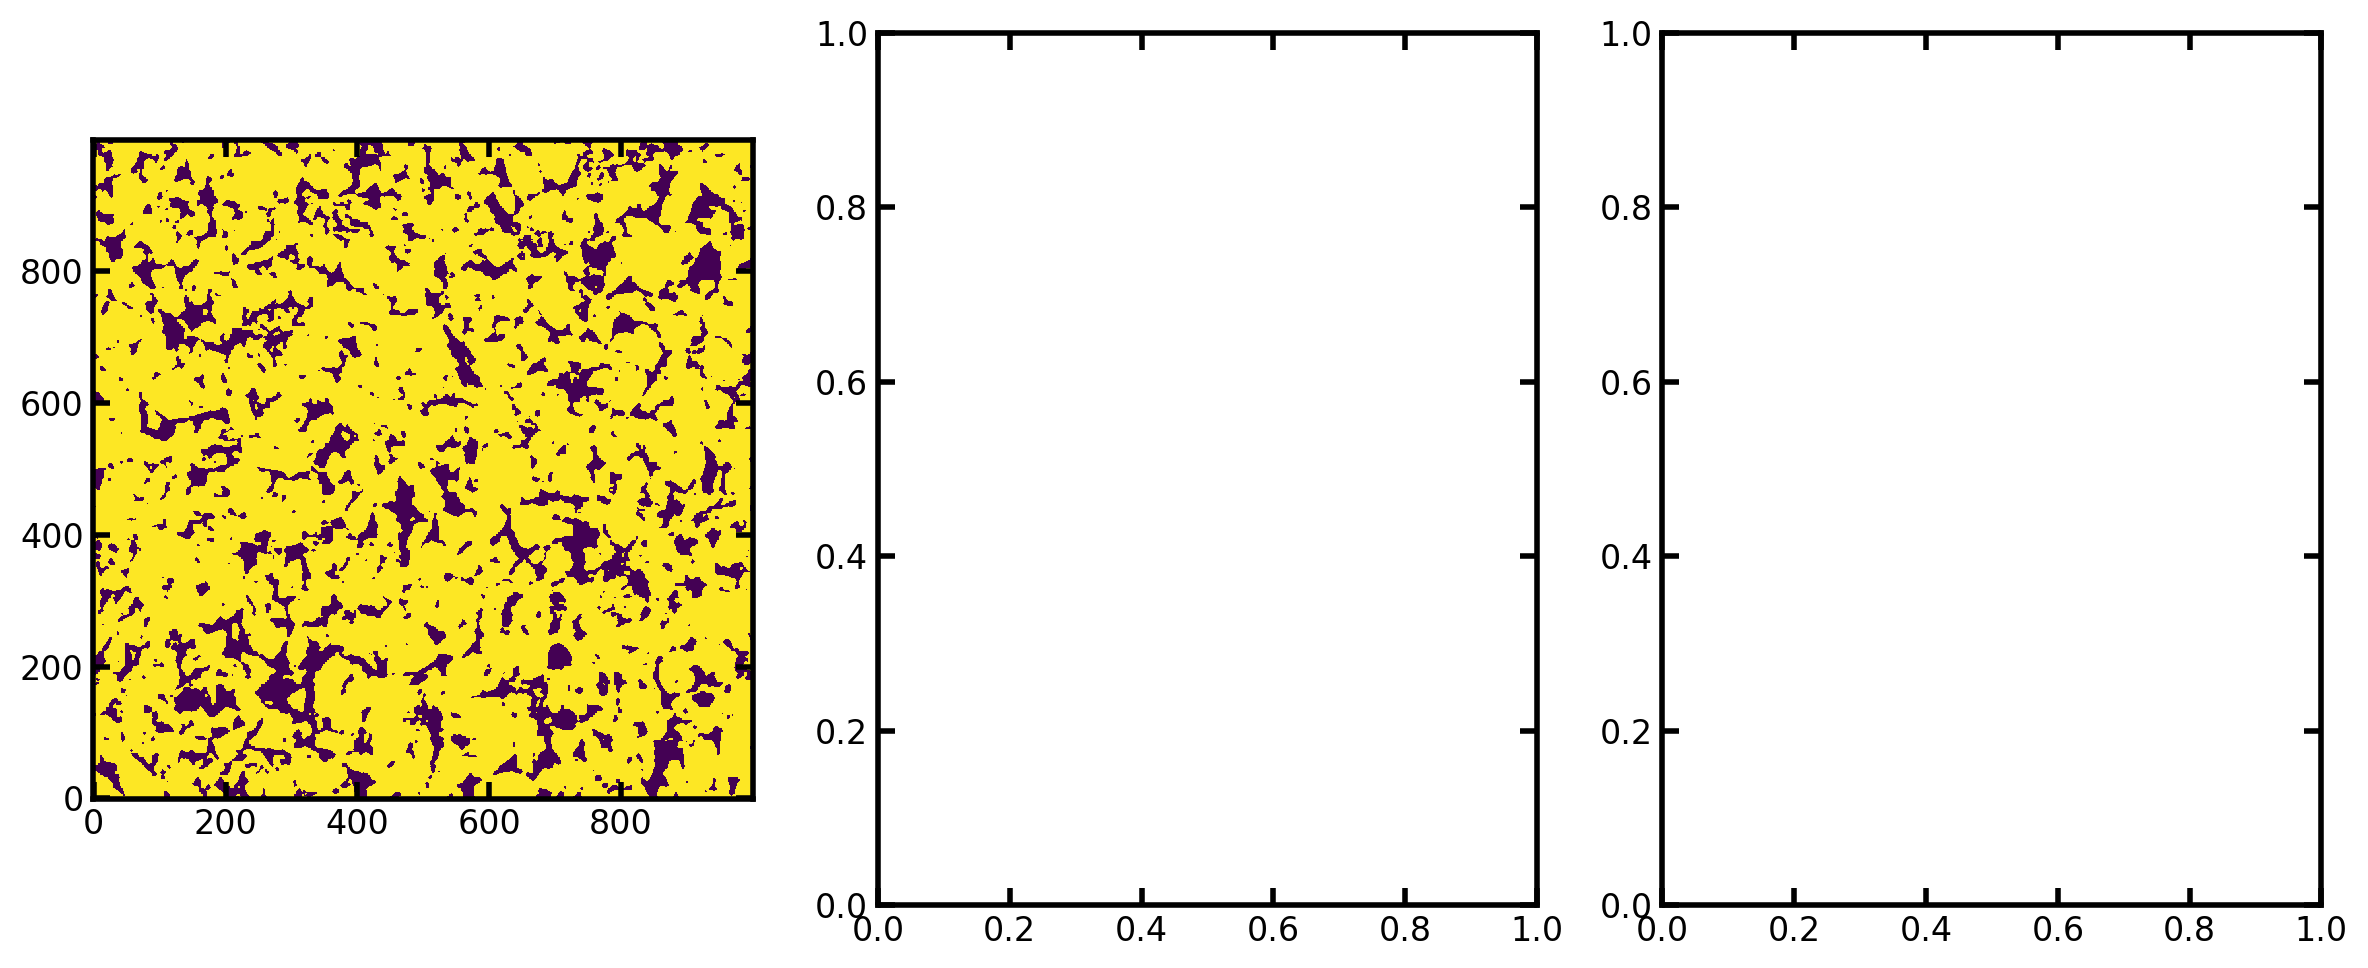

In [2]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'data/Berea_sandstone'
name = 'Berea_2d25um_binary.raw'
data_type = '<i1'
filename = path +'/' + name
# Ensure the directory exists
voxelsx = 1000
voxelsz =1000 #Load the raw image data
voxelsy = 1000

image_data = np.fromfile(filename, dtype=data_type)
# Total number of voxels
total_voxels = image_data.size

# Reshape the image into the inferred 3D dimensions
im = np.reshape(image_data, (voxelsx, voxelsy, voxelsz))
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 100]);
ax[1].imshow(ps.visualization.show_3D(im));
ax[2].imshow(ps.visualization.sem(im));
ax[0].set_title("Slice No. 100 View");
ax[1].set_title("3D Sketch");
ax[2].set_title("SEM View");
